#Setup:
First,load the MNIST dataset, which we will be used in Exercises 1 and 2.

In [1]:
# General imports and data loading for Exercises 1 & 2
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Fetch the MNIST dataset
# This might take a minute the first time you run it
print("Fetching MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X, y = mnist["data"], mnist["target"]
# Convert labels from strings to integers
y = y.astype(np.uint8)
print("Dataset fetched successfully.")

# Split the data into the standard training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Fetching MNIST dataset...
Dataset fetched successfully.


#Why this setup?
fetch_openml() loads from OpenML (public dataset repo).

We use as_frame=False for NumPy arrays (preferred for sklearn).

The dataset has 70,000 images: we split 60k for training and 10k for testing.

#Question 1: MNIST Classifier with >97% Accuracy using KNN
#Goal:
Train a K-Nearest Neighbors (KNN) classifier and tune it using GridSearchCV to get over 97% accuracy.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 1. Define the hyperparameter grid to search
# We'll test a few values for n_neighbors and both weight options.
param_grid = [
    {'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}
]

# 2. Instantiate the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# 3. Instantiate GridSearchCV
# cv=3 means 3-fold cross-validation. verbose=2 will print progress updates.
# n_jobs=-1 tells Colab to use all available processing power.
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# 4. Run the Grid Search on the training data
# !!! WARNING: THIS WILL TAKE A VERY LONG TIME (POSSIBLY 30+ MINUTES) !!!
# K-Nearest Neighbors is very slow on large datasets like MNIST.
print("Starting GridSearchCV for KNeighborsClassifier. This will take a while...")
grid_search.fit(X_train, y_train)

# 5. Display the best results from the search
print("\nGrid Search Complete.")
print("Best hyperparameters found:", grid_search.best_params_)
print("Best cross-validation accuracy on training set:", grid_search.best_score_)

# 6. Evaluate the final model on the test set
# Get the best model found by the grid search
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"\nFinal accuracy on the test set: {final_accuracy * 100:.2f}%")

if final_accuracy > 0.97:
    print("\nSuccessfully achieved over 97% accuracy! 🎉")
else:
    print("\nDid not quite reach 97% accuracy. You could try expanding the param_grid.")

Starting GridSearchCV for KNeighborsClassifier. This will take a while...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Grid Search Complete.
Best hyperparameters found: {'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation accuracy on training set: 0.9703500000000002

Final accuracy on the test set: 97.14%

Successfully achieved over 97% accuracy! 🎉


#MNIST Visualize Predictions from KNN

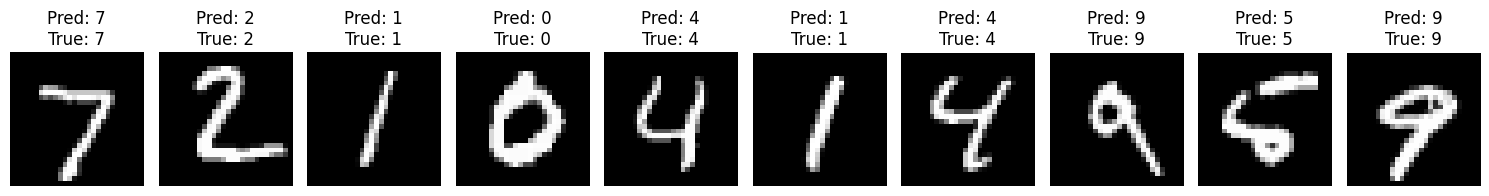

In [4]:
import matplotlib.pyplot as plt

def show_sample_predictions(model, X_test, y_test, count=10):
    plt.figure(figsize=(15, 4))
    for i in range(count):
        image = X_test[i].reshape(28, 28)
        prediction = model.predict([X_test[i]])[0]
        true_label = y_test[i]
        plt.subplot(1, count, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {prediction}\nTrue: {true_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_predictions(final_model, X_test, y_test)


#Question 2: Data Augmentation
#Goal:
Improve accuracy by artificially increasing training data via image shifting.

In [5]:
from scipy.ndimage import shift
import numpy as np

# 1. Write the function to shift an image
def shift_image(image, dx, dy):
    """
    Takes a 784-element vector, reshapes it to 28x28, shifts it,
    and reshapes it back to a 784-element vector.
    """
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

# 2. Create the augmented training set
print("Augmenting training set... (This might take a minute)")
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for image, label in zip(X_train, y_train):
    # Create four shifted copies for each image
    X_train_augmented.append(shift_image(image, 1, 0))  # right
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image, -1, 0)) # left
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image, 0, 1))  # down
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image, 0, -1)) # up
    y_train_augmented.append(label)

# Convert the lists back to NumPy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Shuffle the augmented dataset to ensure randomness during training
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

print(f"Original training set size: {len(X_train)}")
print(f"Augmented training set size: {len(X_train_augmented)}")


# 3. Train the best model from Exercise 1 on the new dataset
# We use the best estimator found by the previous grid search
print("\nTraining the model on the augmented dataset...")
# Note: Re-fitting the KNN model will also be very slow.
final_model.fit(X_train_augmented, y_train_augmented)

# 4. Measure its accuracy on the test set
print("Evaluating model on the test set...")
y_pred_augmented = final_model.predict(X_test)
augmented_accuracy = accuracy_score(y_test, y_pred_augmented)

print(f"\nOriginal accuracy on test set: {final_accuracy * 100:.2f}%")
print(f"Accuracy with data augmentation: {augmented_accuracy * 100:.2f}%")

Augmenting training set... (This might take a minute)
Original training set size: 60000
Augmented training set size: 300000

Training the model on the augmented dataset...
Evaluating model on the test set...

Original accuracy on test set: 97.14%
Accuracy with data augmentation: 97.63%


#MNIST Show Augmented Images

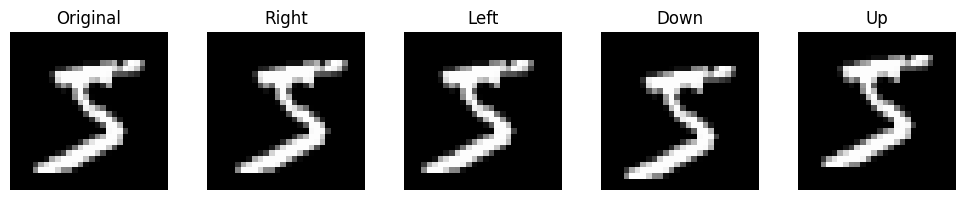

In [6]:
def plot_augmented_examples(original_image):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    shifts = [(0, 0), (1, 0), (-1, 0), (0, 1), (0, -1)]
    titles = ["Original", "Right", "Left", "Down", "Up"]

    for i, (dx, dy) in enumerate(shifts):
        shifted = shift_image(original_image, dx, dy).reshape(28, 28)
        axes[i].imshow(shifted, cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize for a random image from the training set
plot_augmented_examples(X_train[0])


#Question 3: Titanic Survival Prediction
#Goal:
Predict passenger survival using a full pipeline for tabular data preprocessing and classification.

In [8]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Download and load the data directly into Colab
print("Downloading Titanic dataset...")
!wget -q https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/train.csv -O titanic_train.csv
titanic_data = pd.read_csv("titanic_train.csv")

# 2. Separate features (X) and labels (y)
y = titanic_data["Survived"]
X = titanic_data.drop("Survived", axis=1)

# 3. Define the preprocessing pipelines for different column types
# Pipeline for numerical features: impute missing values with the median, then scale.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
])

# Pipeline for categorical features: impute missing values with the most frequent, then one-hot encode.
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder(handle_unknown="ignore")),
])

# 4. Identify which columns are numerical and which are categorical
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

# 5. Create the master preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# 6. Create the full pipeline including the classifier
# RandomForestClassifier is a good choice for this type of data.
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42)),
])

# 7. Train and evaluate the model using cross-validation
print("\nTraining and evaluating the RandomForestClassifier...")
titanic_scores = cross_val_score(full_pipeline, X, y, cv=5)

print(f"\nScores: {titanic_scores}")
print(f"Mean accuracy: {titanic_scores.mean() * 100:.2f}%")
print(f"Standard deviation: {titanic_scores.std():.4f}")


Training and evaluating the RandomForestClassifier...

Scores: [0.77094972 0.79213483 0.85955056 0.78089888 0.8258427 ]
Mean accuracy: 80.59%
Standard deviation: 0.0326


#Titanic Cross-Validation Accuracy Plot

/tmp/ipython-input-9-3853407678.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[1, 2, 3, 4, 5], y=titanic_scores, palette="Blues_d")


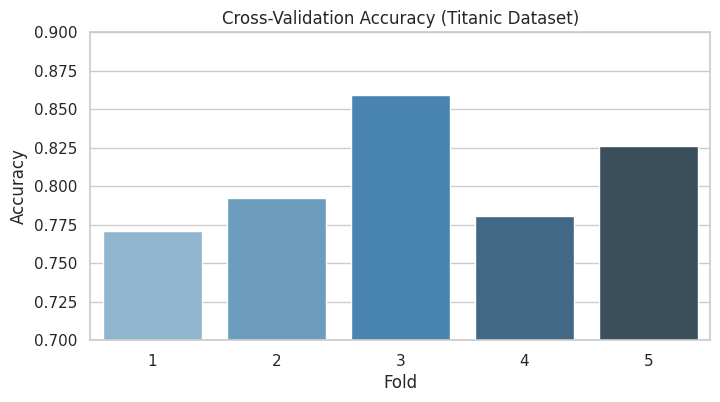

In [9]:
import seaborn as sns

# Plot the CV scores from the 5 folds
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x=[1, 2, 3, 4, 5], y=titanic_scores, palette="Blues_d")
plt.title("Cross-Validation Accuracy (Titanic Dataset)")
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.ylim(0.7, 0.9)
plt.show()


#Question 4: Spam Email Classifier (Text Classification / NLP)
# Goal:
Create a pipeline to detect spam emails using NLP techniques + Logistic Regression.

In [10]:
import os
import tarfile
import urllib.request
from email import message_from_bytes
from email.policy import default
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# === 1. Download and Extract Data ===
def download_and_extract_data():
    """Downloads and extracts the SpamAssassin datasets."""
    print("Downloading SpamAssassin datasets...")
    spam_url = 'https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2'
    ham_url = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2'

    os.makedirs('data', exist_ok=True)
    for url, filename in [(spam_url, 'spam.tar.bz2'), (ham_url, 'ham.tar.bz2')]:
        path = os.path.join('data', filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        with tarfile.open(path) as tar:
            tar.extractall(path='data')

download_and_extract_data()

# === 2. Load and Parse Emails ===
def load_emails_from_dir(path):
    """Loads all email files from a directory."""
    emails = []
    filenames = []
    for filename in os.listdir(path):
        if filename == 'cmds': continue # Skip the 'cmds' file
        with open(os.path.join(path, filename), 'rb') as f:
            emails.append(message_from_bytes(f.read(), policy=default))
            filenames.append(filename)
    return emails, filenames

spam_emails, _ = load_emails_from_dir('data/spam')
ham_emails, _ = load_emails_from_dir('data/easy_ham')
print(f"\nLoaded {len(spam_emails)} spam emails and {len(ham_emails)} ham emails.")

# === 3. Convert Email to Clean Text ===
def email_to_text(email):
    """Extracts the main text content from an email object."""
    text = ""
    for part in email.walk():
        if part.get_content_type() == 'text/plain':
            text += part.get_payload()
    text = text.lower()
    text = re.sub(r'http\S+', 'URL', text) # Replace URLs
    text = re.sub(r'\d+', 'NUMBER', text) # Replace numbers
    text = re.sub(r'\W+', ' ', text, flags=re.MULTILINE) # Remove punctuation
    return text

# === 4. Prepare the Dataset ===
X = [email_to_text(email) for email in spam_emails + ham_emails]
y = np.array([1] * len(spam_emails) + [0] * len(ham_emails)) # 1 for spam, 0 for ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Build and Train the Pipeline ===
# We will use a CountVectorizer and a Logistic Regression classifier
print("\nBuilding and training the spam classification pipeline...")
spam_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42)),
])

spam_pipeline.fit(X_train, y_train)

# === 6. Evaluate the Classifier ===
y_pred = spam_pipeline.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation results on the test set:")
print(f"Precision (how many selected items are relevant?): {precision:.4f}")
print(f"Recall (how many relevant items are selected?):    {recall:.4f}")
print(f"F1-Score (balance between precision and recall):   {f1:.4f}")


Loaded 500 spam emails and 2500 ham emails.

Building and training the spam classification pipeline...

Evaluation results on the test set:
Precision (how many selected items are relevant?): 0.9550
Recall (how many relevant items are selected?):    0.8983
F1-Score (balance between precision and recall):   0.9258


#Spam Classifier  Confusion Matrix

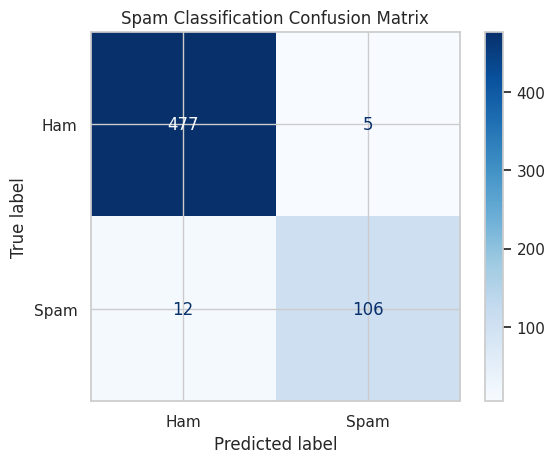

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.title("Spam Classification Confusion Matrix")
plt.show()
